# dp100_13 コンピューティング処理

核実験の実行のランタイムコンテキストは、次の2つの要素で構成される。

- スクリプトの"環境"
    - スクリプトが依存しているすべてのパッケージが含まれる
- "コンピューティング先"
    - 環境がデプロイされ、スクリプトが実行される場所

## 環境の概要

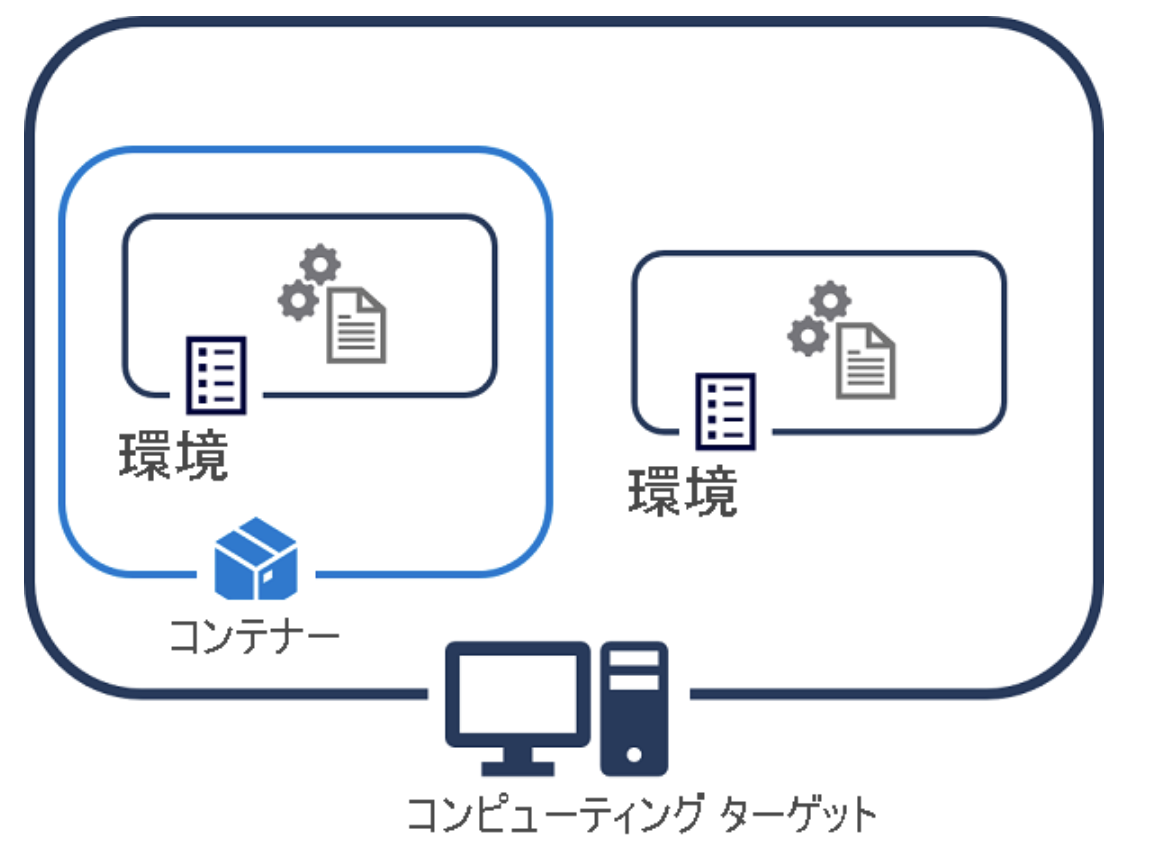

Pythonコードは、使用するPythonランタイムのバージョンと、コードで使用可能なインストール済みパッケージを定義する**仮想環境**のコンテキストで実行される。  
ほとんどのPythonインストールでは、パッケージは**Conda**または**pip**を使用する環境にインストールされて管理される。

移植性を高めるために、通常は、開発用コンピュータ、仮想マシン、またはクラウド上のクラスターなどのコンピューティング先でホストされるDockerコンテナ内に環境を作成する。

### Azure MLにおける環境

一般に、環境の作成とパッケージのインストールは、通常はDockerコンテナの作成を通してAzure MLによって処理される。  
必要なCondaまたはpipパッケージを指定し、実験用の環境の作成をAzureMLに任せることができる。

実験がさまざまなコンピューティングコンテキストで実行されるエンタープライズ機械学習ソリューションでは、  
実験コードが実行される環境に注意することが重要な場合がある。  
環境は**Environment**クラスによってカプセル化され、これを使用して環境を作成し、実験のランタイム構成を指定できる。

環境の作成とパッケージのインストールを管理して環境を定義し、再利用するために登録するタスクをAzureMLに任せることができる。  
または、独自の環境を自分で管理して登録できることにより、実験スクリプトの実行場所に関係なく、一貫性のある再利用可能なランタイムコンテキストを実験に定義できる。

### 環境の作成

環境を作成する方法は複数ある。

#### 仕様ファイルからの環境の作成

Condaまたはpip仕様ファイルを使用して、Python環境で必要なパッケージを定義し、それを使用して**Environment**オブジェクトを作成できる。  
例えば、次のConda構成設定を**conda.yml**という名前のファイルに保存できる。

```
name: py_env
dependencies:
  - numpy
  - pandas
  - scikit-learn
  - pip:
    - azureml-defaults
```

その後、次のコードを使用して、保存した仕様ファイルからAzureML環境を作成できる。

```
from azureml.core import Environment

env = Environment.from_conda_specification(name='training_environment',
                                           file_path='./conda.yml')
```

#### 既存のConda環境から環境を作成する

ワークステーションに既存のConda環境が定義されている場合は、それを使用してAzure ML環境を定義できる。

```
from azureml.core import Environment

env = Environment.from_existing_conda_environment(name='training_environment',
                                                  conda_environment_name='py_env')
```

#### パッケージを指定した環境の作成

以下のように、必要なCondaパッケージとpipパッケージを**CondaDependencies**オブジェクトに指定することで環境を定義できる。

```
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies

env = Environment('training_environment')
deps = CondaDependencies.create(conda_packages=['scikit-learn','pandas','numpy'],
                                pip_packages=['azureml-defaults'])
env.python.conda_dependencies = deps
```

### 開発コンテナの構成

通常、実験スクリプトの環境はコンテナ内に作成される。  
以下のコードは、以前コンテナ内に作成した **env**環境をホストするようにスクリプトベースの実験を構成する。  
※これが規定の設定だが、**use_docker**属性が**False**の**DockerConfiguration**を使用している場合、環境はコンピューティングターゲットに直接作成される。

```
from azureml.core import Experiment, ScriptRunConfig
from azureml.core.runconfig import DockerConfiguration

docker_config = DockerConfiguration(use_docker=True)

script_config = ScriptRunConfig(source_directory='my_folder',
                                script='my_script.py',
                                environment=env,
                                docker_runtime_config=docker_config)
```

AzureMLでは、コンテナ用の基本イメージのライブラリを使用して、指定したコンピューティング先に適したものが選択される。  
(たとえば、GPUベースのコンピューティングにCudaサポートが含まれている)  
カスタムコンテナイメージを作成してコンテナレジストリに登録した場合は、規定の基本イメージを上書きし、独自のイメージを使用できる。  
それには、環境の**docker**プロパティの属性を変更する。

```
env.docker.base_image='my-base-image'
env.docker.base_image_registry='myregistry.azurecr.io/myimage'
```

または、基本イメージとdockerfileの追加設定に基づいて、オンデマンドでイメージを作成することもできる。

```
env.docker.base_image = None
env.docker.base_dockerfile = './Dockerfile'
```

規定では、AzureMLによってPythonのパスとパッケージの依存関係が処理される。  
イメージに必要な依存関係を含むPythonのインストールが既に含まれている場合、**python.user_managed_dependencies**を**True**に設定し、  
インストール用の明示的なpythonパスを指定することで、この動作を上書きできる。

```
env.python.user_managed_dependencies=True
env.python.interpreter_path = '/opt/miniconda/bin/python'
```

### 環境の登録と再利用

環境を作成した後、それをワークスペースに登録し、同じPythonの依存関係を持つ将来の実験で再利用できる。

#### 環境の登録

**Environment**オブジェクトの**register**メソッドを使用して、環境を登録する。

```
env.register(workspace=ws)
```

以下のように、ワークスペースに登録されている環境を表示できる。

```
from azureml.core import Environment

env_names = Environment.list(workspace=ws)
for env_name in env_names:
    print('Name:',env_name)
```

#### 環境の取得と使用

**Environment**クラスの**get**メソッドを使用して登録済みの環境を取得し、それを**ScriptRunConfig**に割り当てることができる。  
たとえば、以下のコードサンプルでは登録済みの*training_environment*環境が取得され、それがスクリプト実行構成に割り当てられる。

```
from azureml.core import Environment, ScriptRunConfig

training_env = Environment.get(workspace=ws, name='training_environment')

script_config = ScriptRunConfig(source_directory='my_folder',
                                script='my_script.py',
                                environment=training_env)
```

推定器に基づく実験が実行される時、AzureMLによって定義と一致する既存の環境が検索され、  
存在しない場合は、登録済みの環境の仕様に基づいて新しい環境が作成される。

## コンピューティング先の概要

### コンピューティングの種類

- **ローカルコンピューティング**
    - AzureMLのほとんどの処理タスクのためにローカルコンピューティング先を指定できる。  
    ここでは、実験を開始するために使用したコードと同じコンピューティング先で実験が実行される。  
    これは、物理的なワークステーションやノートブックを実行しているAzureMLコンピューティングインスタンスなどの仮想マシンが可能。  
    ローカルコンピューティングは、一般に少量から中程度の量のデータを使用して開発とテストを行うときに最適
- **コンピューティングクラスター**
    - 高いスケーラビリティという要件がある実験ワークロードの場合は、AzureMLコンピューティングクラスターを使用できる。  
    これは、需要に合わせて自動的にスケールアップまたはダウンされるVMのマルチノードクラスター。  
    大量データを処理するか、並行処理を使用してロードバランスして実行にかかる時間を短縮する必要がある実験のためのコスト効率がいい方法
- **アタッチされたコンピューティング**
    - データサイエンスのための仮想マシンやAzure DatabricksクラスターなどのAzureベースのコンピューティング環境を既に使用している場合は、  
    それをAzureMLワークスペースにアタッチし、特定の種類のワークロードのコンピューティング先として使用できる。

> 注:推論クラスターという別の種類のコンピューティングをスタジオでは作成できるが、  
この種のコンピューティングはAzure Kubernetes Serviceクラスターを表し、トレーニング済みのモデルを推論サービスとしてデプロイする場合にのみ使用する

実験の実行を特定のコンピューティング先に割り当てる機能を使用すると、次の方法で柔軟なシステムを実装できる。

- ローカルまたは低コストのコンピューティングでコードを開発してテストしたあと、運用ワークロード用のスケーラブルなコンピューティングに移行できる
- 個々のプロセスを、ニーズに最も適したコンピューティング先で実行できる。例えば、GPUベースのコンピューティングを使用してディープラーニングモデルをトレーニングし、  
低コストのCPUのみのコンピューティングに切り替えて、トレーニング済みのモデルのテストと登録を行う。

クラウドコンピューティングの主な利点の一つは、使用した分だけ料金を支払うことでコストを管理できること。  
AzureMLでは、次のようなコンピューティング先を定義することによって、この原則を活用できる。

- オンデマンドで開始し、不要になった時に自動的に停止する
- ワークロード処理のニーズに基づいて自動的にスケーリングを行う

## コンピューティング先を作成する

コンピューティング先を作成またはアタッチする一般的な方法は、以下の2パターン。

- AzureMLスタジオの**コンピューティング**ページを使用する
- AzureML SDKを使用してコードでコンピューティング先をプロビジョニングする

### SDKを使用したマネージドコンピューティング先の作成

"マネージド"コンピューティング先は、AzureMLによって管理されているコンピューティング先。  
AzureMLコンピューティングクラスターを作成するには、以下のように**azureml.core.compute.ComputeTarget**クラスと**AmCompute**クラスを使用する。

```
from azureml.core import Workspace
from azureml.core.compute import ComputeTarget, AmlCompute

# 保存した設定ファイルからワークスペースを読み込む
ws = Workspace.from_config()

# コンピューティング名を指定
compute_name = 'aml-cluster'

# コンピューティングの設定を定義
compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_DS11_V2',
                                                       min_nodes=0, max_nodes=4,
                                                       vm_priority='dedicated')

# コンピューティング作成
aml_cluster = ComputeTarget.create(ws, compute_name, compute_config)
aml_cluster.wait_for_completion(show_output=True)
```

この例では、STANDARD_DS12_v2仮想足んイメージ基づく最大4つのノードがあるクラスターが作成される。  
仮想マシンの優先度は専用に設定されているため、このクラスターで使用するために予約されている。  
(*lowpriority*を指定することもできる。これを指定するとコストは低くなるが、  
優先度の高いワークロードでコンピューティングが必要になったときに割り込まれる発生が高くなる)

**AmlCompute**構成オプションの完全な一覧:https://aka.ms/AA70zfq

### アンマネージドコンピューティング先のSDKへのアタッチ

"アンマネージド"コンピューティング先とは、AzureMLのワークスペースの外部で定義と管理が行われるコンピューティング先。  
たとえば、Azure仮想マシンやAzure Databricksクラスターが当てはまる。

既存のアンマネージとコンピューティング先をアタッチするためのコードは、マネージドコンピューティング先を作成するために使用するコードに似ている。  
ただし、ターゲット固有の構成設定に基づいて既存のコンピューティングをアタッチするには、**ComputeTarget.attach()**メソッドを使用する必要がある。

例えば、次のコードを使用して、既存のAzure Databricksクラスターをアタッチできる。

```
from azureml.core import Workspace
from azureml.core.compute import ComputeTarget, DatabricksCompute

# 保存した設定ファイルからワークスペースを読み込む
ws = Workspace.from_config()

# コンピューティング名を指定
compute_name = 'db_cluster'

# 既存のAzure Databricksクラスタの構成を定義
db_workspace_name = 'db_workspace'
db_resource_group = 'db_resource_group'
db_access_token = '1234-abc-5678-defg-90...'
db_config = DatabricksCompute.attach_configuration(resource_group=db_resource_group,
                                                   workspace_name=db_workspace_name,
                                                   access_token=db_access_token)

# コンピューティング作成
databricks_compute = ComputeTarget.attach(ws, compute_name, db_config)
databricks_compute.wait_for_completion(True)
```

### 既存のコンピューティング先の確認

多くの場合、コンピューティング先が存在するかどうかを確認し、指定された名前を持つ新しいものが存在しない場合にのみ、新しいターゲットを作成する。  
これを実現するには、次のように**ComputeTargetException**例外をキャッチする。

```
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

compute_name = "aml-cluster"

# コンピューティング先が存在するか確認
try:
    aml_cluster = ComputeTarget(workspace=ws, name=compute_name)
    print('Found existing cluster.')
except ComputeTargetException:
    # If not, create it
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_DS11_V2',
                                                           max_nodes=4)
    aml_cluster = ComputeTarget.create(ws, compute_name, compute_config)

aml_cluster.wait_for_completion(show_output=True)
```

コンピューティング先の作成の詳細:https://aka.ms/AA70rrg

## コンピューティング先を使用する

ワークスペースにコンピューティング先を作成するかアタッチした後、それらを使用して実験など特定のワークロードを実行できる。  
特定のコンピューティング先を使用するには、実験の実行構成または推定器の適切なパラメータにそれを指定できる。  
たとえば、次のコードでは*aml-cluster*という名前でコンピューティング先を使用するように推定機を構成している。

```
from azureml.core import Environment, ScriptRunConfig

compute_name = 'aml-cluster'

training_env = Environment.get(workspace=ws, name='training_environment')

script_config = ScriptRunConfig(source_directory='my_dir',
                                script='script.py',
                                environment=training_env,
                                compute_target=compute_name)
```

実験が送信されると、*aml-cluster*コンピューティング先が開始され、指定された環境が作成されている間、実行がキューに登録され、  
その後コンピューティング環境で実行が処理される。

コンピューティング先の名前を指定する代わりに、次のように**ComputeTarget**オブジェクトを指定できる。

```
from azureml.core import Environment, ScriptRunConfig
from azureml.core.compute import ComputeTarget

compute_name = "aml-cluster"

training_cluster = ComputeTarget(workspace=ws, name=compute_name)

training_env = Environment.get(workspace=ws, name='training_environment')

script_config = ScriptRunConfig(source_directory='my_dir',
                                script='script.py',
                                environment=training_env,
                                compute_target=training_cluster)
```

## 演習 コンピューティングコンテキストを操作する

### ワークスペースへの接続

In [13]:
import azureml.core
from azureml.core import Workspace

# Load the workspace from the saved config file
ws = Workspace.from_config()
print('Ready to use Azure ML {} to work with {}'.format(azureml.core.VERSION, ws.name))

Ready to use Azure ML 1.28.0 to work with 20210613


### 実験用データの準備

糖尿病データセットを準備する。

In [14]:
ws.datasets['diabetes dataset']

{
  "source": [
    "('workspaceblobstore', 'diabetes-data/*.csv')"
  ],
  "definition": [
    "GetDatastoreFiles",
    "ParseDelimited",
    "DropColumns",
    "SetColumnTypes"
  ],
  "registration": {
    "id": "34c69dce-293a-4864-9539-305b47c0bf6e",
    "name": "diabetes dataset",
    "version": 1,
    "description": "diabetes data",
    "tags": {
      "format": "CSV"
    },
    "workspace": "Workspace.create(name='20210613', subscription_id='153404fd-72ab-4092-b50e-de490c5509fc', resource_group='20210613')"
  }
}

In [15]:
from azureml.core import Dataset

default_ds = ws.get_default_datastore()

if 'diabetes dataset' not in ws.datasets:
    default_ds.upload_files(files=['./data/diabetes.csv', './data/diabetes2.csv'], # Upload the diabetes csv files in /data
                        target_path='diabetes-data/', # Put it in a folder path in the datastore
                        overwrite=True, # Replace existing files of the same name
                        show_progress=True)

    #Create a tabular dataset from the path on the datastore (this may take a short while)
    tab_data_set = Dataset.Tabular.from_delimited_files(path=(default_ds, 'diabetes-data/*.csv'))

    # Register the tabular dataset
    try:
        tab_data_set = tab_data_set.register(workspace=ws, 
                                name='diabetes dataset',
                                description='diabetes data',
                                tags = {'format':'CSV'},
                                create_new_version=True)
        print('Dataset registered.')
    except Exception as ex:
        print(ex)
else:
    print('Dataset already registered.')

Dataset already registered.


### 訓練用スクリプトの作成

新規の実験用フォルダおよび訓練用スクリプト(scikit-learnとmatplotlib)を作成する

In [16]:
import os

# 実験ファイル用フォルダの作成
experiment_folder = 'diabetes_training_logistic'
os.makedirs(experiment_folder, exist_ok=True)
print(experiment_folder, 'folder created')

diabetes_training_logistic folder created


In [17]:
%%writefile $experiment_folder/diabetes_training.py
# Import libraries
import argparse
from azureml.core import Run
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Get script arguments
parser = argparse.ArgumentParser()
parser.add_argument('--regularization', type=float, dest='reg_rate', default=0.01, help='regularization rate')
parser.add_argument("--input-data", type=str, dest='training_dataset_id', help='training dataset')
args = parser.parse_args()

# Set regularization hyperparameter
reg = args.reg_rate

# Get the experiment run context
run = Run.get_context()

# load the diabetes data (passed as an input dataset)
print("Loading Data...")
diabetes = run.input_datasets['training_data'].to_pandas_dataframe()

# Separate features and labels
X, y = diabetes[['Pregnancies','PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age']].values, diabetes['Diabetic'].values

# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Train a logistic regression model
print('Training a logistic regression model with regularization rate of', reg)
run.log('Regularization Rate',  np.float(reg))
model = LogisticRegression(C=1/reg, solver="liblinear").fit(X_train, y_train)

# calculate accuracy
y_hat = model.predict(X_test)
acc = np.average(y_hat == y_test)
print('Accuracy:', acc)
run.log('Accuracy', np.float(acc))

# calculate AUC
y_scores = model.predict_proba(X_test)
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))
run.log('AUC', np.float(auc))

# plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
fig = plt.figure(figsize=(6, 4))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
run.log_image(name = "ROC", plot = fig)
plt.show()

os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=model, filename='outputs/diabetes_model.pkl')

run.complete()

Overwriting diabetes_training_logistic/diabetes_training.py


### 環境を定義する

AzureeMLの実験としてPythonスクリプトを実行すると、スクリプトのスクリプトの実行コンテキストを定義するためにConda環境が作成される。  
AzureMLは、実験の実行に必要なライブラリを含む**azureml-defaults**や**pandas**、**numpy**などの一般的なパッケージなど、  
多くの一般的なパッケージを含むデフォルト環境を提供する。

また、condaやpipを使って独自の環境を定義し、パッケージを追加することで、実験に必要なすべてのライブラリにアクセスできるようになる。

> 注:condaの依存パッケージが最初にインストールされ、次にpipの依存パッケージがインストールされる。  
pipパッケージはpipの依存関係をインストールするのに必要なので、condaの依存関係に含めておくのが良いでしょう。  
※忘れてもAzureMLがインストールしてくれるが、ログに警告が表示される

In [18]:
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies

# 実験用のPython環境構築
diabetes_env = Environment("diabetes-experiment-env")
diabetes_env.python.user_managed_dependencies = False # Let Azure ML manage dependencies

# パッケージの依存関係のセットを作成
diabetes_packages = CondaDependencies.create(conda_packages=['scikit-learn','ipykernel','matplotlib','pandas','pip'],
                                             pip_packages=['azureml-sdk','pyarrow'])

# 環境に依存関係を追加
diabetes_env.python.conda_dependencies = diabetes_packages

print(diabetes_env.name, 'defined.')

diabetes-experiment-env defined.


In [19]:
diabetes_env

{
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04:20210301.v1",
        "baseImageRegistry": {
            "address": null,
            "password": null,
            "registryIdentity": null,
            "username": null
        },
        "enabled": false,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": "2g"
    },
    "environmentVariables": {
        "EXAMPLE_ENV_VAR": "EXAMPLE_VALUE"
    },
    "inferencingStackVersion": null,
    "name": "diabetes-experiment-env",
    "python": {
        "baseCondaEnvironment": null,
        "condaDependencies": {
            "channels": [
                "anaconda",
                "con

次のコードでは、作成した環境をScriptRunConfigに割り当て、実験を送信している。  
実験が実行されると、ウィジェットで実行の詳細を観察し、**azureml_logs/60_control_log.txt**の出力ログは、conda環境が構築されていることがわかる。

> 注:以下のコードでは、スクリプトの実行用に**DockerConfiguration**を作成し、その**use_docker**属性を**True**に設定して、スクリプトの環境をDockerコンテナでホストするようにしている。  
これはデフォルトの動作なので省略することもできるが、ここでは明確にするために含まれている。

In [20]:
from azureml.core import Experiment, ScriptRunConfig
from azureml.core.runconfig import DockerConfiguration
from azureml.widgets import RunDetails

# 訓練用データセットの取得
diabetes_ds = ws.datasets.get("diabetes dataset")

# スクリプトコンフィグの作成
script_config = ScriptRunConfig(source_directory=experiment_folder,
                                script='diabetes_training.py',
                                arguments = ['--regularization', 0.1, # Regularizaton rate parameter
                                             '--input-data', diabetes_ds.as_named_input('training_data')], # Reference to dataset
                                environment=diabetes_env,
                                docker_runtime_config=DockerConfiguration(use_docker=True)) # Use docker to host environment

# 実験の実行
experiment_name = 'mslearn-train-diabetes'
experiment = Experiment(workspace=ws, name=experiment_name)
run = experiment.submit(config=script_config)
RunDetails(run).show()
run.wait_for_completion()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

{'runId': 'mslearn-train-diabetes_1623671994_4bd7698d',
 'target': 'local',
 'status': 'Completed',
 'startTimeUtc': '2021-06-14T12:05:18.722182Z',
 'endTimeUtc': '2021-06-14T12:05:38.118028Z',
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': '824fa375-becf-465c-8975-bb0d6a11a869',
  'azureml.git.repository_uri': 'https://github.com/iguru0331/mslearn-dp100.git',
  'mlflow.source.git.repoURL': 'https://github.com/iguru0331/mslearn-dp100.git',
  'azureml.git.branch': 'main',
  'mlflow.source.git.branch': 'main',
  'azureml.git.commit': '9e7541ac0a3b8687508ec55f4450f2e08432e185',
  'mlflow.source.git.commit': '9e7541ac0a3b8687508ec55f4450f2e08432e185',
  'azureml.git.dirty': 'True'},
 'inputDatasets': [{'dataset': {'id': '34c69dce-293a-4864-9539-305b47c0bf6e'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'training_data', 'mechanism': 'Direct'}}],
 'outputDatasets': [],
 'runDefinition': {'script': 'diabetes_training.py',
  'command': '',
  'useAbso

実験では、必要なパッケージが全て含まれた環境を使用することができた。  
AzureMLスタジオで実行された実験のメトリックと出力、または以下のコードを実行することで、scikit-learnを使用してトレーニングされたモデルや、  
**matplotlib**を使用して生成されたROCチャート画像などを見ることができる。

In [21]:
# Get logged metrics
metrics = run.get_metrics()
for key in metrics.keys():
        print(key, metrics.get(key))
print('\n')
for file in run.get_file_names():
    print(file)

Regularization Rate 0.1
Accuracy 0.7891111111111111
AUC 0.8568509052814499
ROC aml://artifactId/ExperimentRun/dcid.mslearn-train-diabetes_1623671994_4bd7698d/ROC_1623672327.png


ROC_1623672327.png
azureml-logs/60_control_log.txt
azureml-logs/70_driver_log.txt
logs/azureml/9_azureml.log
logs/azureml/dataprep/backgroundProcess.log
logs/azureml/dataprep/backgroundProcess_Telemetry.log
outputs/diabetes_model.pkl


### 環境の登録

必要なパッケージを含む環境を定義したら、それをワークスペースに登録することができる。

In [23]:
# 環境の登録
diabetes_env.register(workspace=ws)

{
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04:20210301.v1",
        "baseImageRegistry": {
            "address": null,
            "password": null,
            "registryIdentity": null,
            "username": null
        },
        "enabled": false,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": null
    },
    "environmentVariables": {
        "EXAMPLE_ENV_VAR": "EXAMPLE_VALUE"
    },
    "inferencingStackVersion": null,
    "name": "diabetes-experiment-env",
    "python": {
        "baseCondaEnvironment": null,
        "condaDependencies": {
            "channels": [
                "anaconda",
                "con

環境は、最初に作成したときに名前で登録されることに注意すること。　※ここではdiabetes-experiment-env

環境が登録されると、同じ要件のスクリプトに再利用できるようになる。  
例えば、別のアルゴリズムを使って糖尿病モデルをトレーニングするためのフォルダとスクリプトを作成する。

In [24]:
import os

# Create a folder for the experiment files
experiment_folder = 'diabetes_training_tree'
os.makedirs(experiment_folder, exist_ok=True)
print(experiment_folder, 'folder created')

diabetes_training_tree folder created


In [33]:
%%writefile $experiment_folder/diabetes_training.py
# Import libraries
import argparse
from azureml.core import Run
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# スクリプト引数の取得
parser = argparse.ArgumentParser()
parser.add_argument("--input-data", type=str, dest='training_dataset_id', help='training dataset')
args = parser.parse_args()

# 実験の実行コンテキストの取得
run = Run.get_context()

# 糖尿病データの取得
print("Loading Data...")
diabetes = run.input_datasets['training_data'].to_pandas_dataframe()

# 特徴量とラベルの分離
X, y = diabetes[['Pregnancies','PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age']].values, diabetes['Diabetic'].values

# 訓練データとテストデータの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# 決定木モデルの訓練
print('Training a decision tree model')
model = DecisionTreeClassifier().fit(X_train, y_train)

# 精度計算
y_hat = model.predict(X_test)
acc = np.average(y_hat == y_test)
print('Accuracy:', acc)
run.log('Accuracy', np.float(acc))

# AUC計算
y_scores = model.predict_proba(X_test)
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))
run.log('AUC', np.float(auc))

# ROC曲線出力
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
fig = plt.figure(figsize=(6, 4))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
run.log_image(name = "ROC", plot = fig)
plt.show()

os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=model, filename='outputs/diabetes_model.pkl')

run.complete()

Overwriting diabetes_training_tree/diabetes_training.py


これで、登録された環境を取得し、別の学習スクリプトを実行する新しい実験で使用することができる。  
※決定木分類では正規化パラメータが必要ないため、今回は正規化パラメータはない。

In [34]:
# 登録済み環境を取得
registered_env = Environment.get(ws, 'diabetes-experiment-env')

# トレーニングデータセットの取得
diabetes_ds = ws.datasets.get("diabetes dataset")

# スクリプトコンフィグの作成
script_config = ScriptRunConfig(source_directory=experiment_folder,
                              script='diabetes_training.py',
                              arguments = ['--input-data', diabetes_ds.as_named_input('training_data')], # Reference to dataset
                              environment=registered_env,
                              docker_runtime_config=DockerConfiguration(use_docker=True)) # Use docker to host environment 

In [35]:
# 実験の実行
experiment_name = 'mslearn-train-diabetes'
experiment = Experiment(workspace=ws, name=experiment_name)
run = experiment.submit(config=script_config)
RunDetails(run).show()
run.wait_for_completion()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

{'runId': 'mslearn-train-diabetes_1623684290_61905134',
 'target': 'local',
 'status': 'Finalizing',
 'startTimeUtc': '2021-06-14T15:24:52.334721Z',
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': '4f534cff-1dfe-4a5d-bfe4-71c0154f7d1e',
  'azureml.git.repository_uri': 'https://github.com/iguru0331/mslearn-dp100.git',
  'mlflow.source.git.repoURL': 'https://github.com/iguru0331/mslearn-dp100.git',
  'azureml.git.branch': 'main',
  'mlflow.source.git.branch': 'main',
  'azureml.git.commit': '9e7541ac0a3b8687508ec55f4450f2e08432e185',
  'mlflow.source.git.commit': '9e7541ac0a3b8687508ec55f4450f2e08432e185',
  'azureml.git.dirty': 'True'},
 'inputDatasets': [{'dataset': {'id': '34c69dce-293a-4864-9539-305b47c0bf6e'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'training_data', 'mechanism': 'Direct'}}],
 'outputDatasets': [],
 'runDefinition': {'script': 'diabetes_training.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--input-da

今回の実験では、前回の実行時にマッチした環境がキャッシュされているため、ローカルコンピューティング上で環境を再構築する必要がなく、より迅速に実験を行うことができる。  
しかし、異なるコンピュートターゲットであっても、同じ環境が作成、使用されるため、実験スクリプトの実験コンテキストの一貫性が確保される。

この実験で得られたメトリックとアウトプットを見てみる。

In [36]:
# Get logged metrics
metrics = run.get_metrics()
for key in metrics.keys():
        print(key, metrics.get(key))
print('\n')
for file in run.get_file_names():
    print(file)

Accuracy 0.8986666666666666
AUC 0.8835941571454989
ROC aml://artifactId/ExperimentRun/dcid.mslearn-train-diabetes_1623684290_61905134/ROC_1623684300.png


ROC_1623684300.png
azureml-logs/60_control_log.txt
azureml-logs/70_driver_log.txt
logs/azureml/8_azureml.log
logs/azureml/dataprep/backgroundProcess.log
logs/azureml/dataprep/backgroundProcess_Telemetry.log
outputs/diabetes_model.pkl


### 登録された環境を見る

独自の環境を登録するだけでなく、一般的な実験タイプのために予め構築された「キュレートされた(収集されまとめられた)」環境を利用することもできる。  
以下のコードは、登録されているすべての環境を示している。

In [37]:
from azureml.core import Environment

envs = Environment.list(workspace=ws)
for env in envs:
    print("Name",env)

Name diabetes-experiment-env
Name AzureML-PyTorch-1.3-CPU
Name AzureML-Minimal
Name AzureML-Tutorial
Name AzureML-Dask-CPU
Name AzureML-Dask-GPU
Name AzureML-VowpalWabbit-8.8.0
Name AzureML-TensorFlow-2.3-CPU
Name AzureML-Triton
Name AzureML-PyTorch-1.6-CPU
Name AzureML-PyTorch-1.6-GPU
Name AzureML-TensorFlow-2.3-GPU
Name AzureML-DeepSpeed-0.3-GPU
Name AzureML-tensorflow-2.4-ubuntu18.04-py37-cuda11-gpu
Name AzureML-tensorflow-1.15-ubuntu18.04-py37-cpu-inference
Name AzureML-sklearn-0.24-ubuntu18.04-py37-cuda11-gpu
Name AzureML-tensorflow-2.4-ubuntu18.04-py37-cpu-inference
Name AzureML-tensorflow-2.4-ubuntu18.04-py37-cuda11.0.3-gpu-inference
Name AzureML-pytorch-1.7-ubuntu18.04-py37-cpu-inference
Name AzureML-pytorch-1.7-ubuntu18.04-py37-cuda11-gpu
Name AzureML-tritonserver-21.02-py38-inference
Name AzureML-sklearn-0.24.1-ubuntu18.04-py37-cpu-inference
Name AzureML-minimal-ubuntu18.04-py37-cpu-inference
Name AzureML-onnxruntime-1.6-ubuntu18.04-py37-cpu-inference
Name AzureML-xgboost-0.9

すべてのキュレーションされた環境は、**AzureML-**で始まる名前をもっている。(自分の環境にこのプレフィックスを使用することはできない)。  
それでは、キューレーションされた環境をさらに詳しく調べ、それぞれにどのようなパッケージが含まれているかを見てみる。

In [41]:
for env in envs:
    if env.startswith("AzureML"):
        print("Name",env)
        print("packages", envs[env].python.conda_dependencies.serialize_to_string())

Name AzureML-PyTorch-1.3-CPU
packages channels:
- conda-forge
dependencies:
- python=3.6.2
- pip=20.2.4
- pip:
  - azureml-core==1.21.0.post1
  - azureml-defaults==1.21.0
  - azureml-telemetry==1.21.0
  - azureml-train-restclients-hyperdrive==1.21.0
  - azureml-train-core==1.21.0
  - torch==1.3
  - torchvision==0.4.1
  - mkl==2018.0.3
  - horovod==0.18.1
  - tensorboard==1.14.0
  - future==0.17.1
name: azureml_a02f4fa469cd8066bd6e2f219433318d

Name AzureML-Minimal
packages channels:
- conda-forge
dependencies:
- python=3.6.2
- pip:
  - azureml-core==1.30.0
  - azureml-defaults==1.30.0
name: azureml_e90e0f5245bd5c557f2051c72a90db49

Name AzureML-Tutorial
packages channels:
- anaconda
- conda-forge
dependencies:
- python=3.6.2
- pip:
  - azureml-core==1.30.0
  - azureml-defaults==1.30.0
  - azureml-telemetry==1.30.0
  - azureml-train-restclients-hyperdrive==1.30.0
  - azureml-train-core==1.30.0
  - azureml-widgets==1.30.0
  - azureml-pipeline-core==1.30.0
  - azureml-pipeline-steps==1.30

### コンピューティングクラスターの作成

大量のデータを処理する必要がある複雑な実験や長期間に渡る実験を処理するには、ローカルのコンピューティングリソースだけでは不十分な場合が多い。  
コンピューティングクラスターは、AzureMLスタジオ、またはAzureML SDKを使用して作成できる。  
次のコードでは、ワークスペースに指定した名前のコンピュートクラスターが存在するかどうかを確認し、存在しない場合は作成する。

In [45]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

cluster_name = "msl-20210613b"

try:
    # Check for existing compute target
    training_cluster = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    # If it doesn't already exist, create it
    try:
        compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_DS11_V2', max_nodes=2)
        training_cluster = ComputeTarget.create(ws, cluster_name, compute_config)
        training_cluster.wait_for_completion(show_output=True)
    except Exception as ex:
        print(ex)

Creating.........
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


### リモートコンピューティングでの実験の実行

これで、前回実行した実験を今回は作成したコンピューティングクラスター上で再実行する準備が整った。

> 注:スクリプトを実行する前に、conda環境でコンテナイメージをビルドし、クラスタノードを起動してイメージをデプロイする必要があるため、実験が長時間かかる。  
糖尿病トレーニングスクリプトのような単純な実験では、これは非効率的に思えるかも知れないが、数時間かかる複雑な実験を実行する必要があるとしたら、  
よりスケーラブルなコンピュートを動的に作成することで、全体の時間を大幅に短縮できるかもしれない。

In [46]:
# Create a script config
script_config = ScriptRunConfig(source_directory=experiment_folder,
                                script='diabetes_training.py',
                                arguments = ['--input-data', diabetes_ds.as_named_input('training_data')],
                                environment=registered_env,
                                compute_target=cluster_name) 

# submit the experiment
experiment_name = 'mslearn-train-diabetes'
experiment = Experiment(workspace=ws, name=experiment_name)
run = experiment.submit(config=script_config)
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

実験の実行を待っている間に、上のウィジェットやAzureMLスタジオでコンピューティングの状態を確認できる。  
また、以下のコードを使ってコンピューティングの状態を確認することができる。

In [53]:
cluster_state = training_cluster.get_status()
print(cluster_state.allocation_state, cluster_state.current_node_count)

Steady 1


なお、ステータスが定常状態からサイズ変更になるまでにはしばらく時間がかかる。  
実行が完了するまでカーネルをブロックするには、以下のセルを実行する。

In [50]:
run.wait_for_completion()

{'runId': 'mslearn-train-diabetes_1623685390_cc8ed8ca',
 'target': 'msl-20210613b',
 'status': 'Finalizing',
 'startTimeUtc': '2021-06-14T15:56:33.77773Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '4f534cff-1dfe-4a5d-bfe4-71c0154f7d1e',
  'azureml.git.repository_uri': 'https://github.com/iguru0331/mslearn-dp100.git',
  'mlflow.source.git.repoURL': 'https://github.com/iguru0331/mslearn-dp100.git',
  'azureml.git.branch': 'main',
  'mlflow.source.git.branch': 'main',
  'azureml.git.commit': '9e7541ac0a3b8687508ec55f4450f2e08432e185',
  'mlflow.source.git.commit': '9e7541ac0a3b8687508ec55f4450f2e08432e185',
  'azureml.git.dirty': 'True',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': '34c69dce-293a-4864-9539-305b47c0bf6e'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'training_data', 'mechanism': 'Direct'}}],
 'outputDatasets': [],

実験が終了すると、実験の実行によって生成されたメトリックやファイルを取得することができる。  
今回のファイルには、イメージの構築やコンピューティングの管理に関するログが含まれている。

In [51]:
# Get logged metrics
metrics = run.get_metrics()
for key in metrics.keys():
        print(key, metrics.get(key))
print('\n')
for file in run.get_file_names():
    print(file)

Accuracy 0.8991111111111111
AUC 0.8840918562273435
ROC aml://artifactId/ExperimentRun/dcid.mslearn-train-diabetes_1623685390_cc8ed8ca/ROC_1623686299.png


ROC_1623686299.png
azureml-logs/20_image_build_log.txt
azureml-logs/55_azureml-execution-tvmps_545939a865c9d22877943afd4588c18a2a241c5c6d28559187f7a4f06bee28a5_d.txt
azureml-logs/65_job_prep-tvmps_545939a865c9d22877943afd4588c18a2a241c5c6d28559187f7a4f06bee28a5_d.txt
azureml-logs/70_driver_log.txt
azureml-logs/75_job_post-tvmps_545939a865c9d22877943afd4588c18a2a241c5c6d28559187f7a4f06bee28a5_d.txt
azureml-logs/process_info.json
azureml-logs/process_status.json
logs/azureml/95_azureml.log
logs/azureml/dataprep/backgroundProcess.log
logs/azureml/dataprep/backgroundProcess_Telemetry.log
logs/azureml/job_prep_azureml.log
logs/azureml/job_release_azureml.log
outputs/diabetes_model.pkl


これで、実験を学習させたモデルを登録することができる。

In [52]:
from azureml.core import Model

# モデルの登録
run.register_model(model_path='outputs/diabetes_model.pkl', model_name='diabetes_model',
                   tags={'Training context':'Compute cluster'}, properties={'AUC': run.get_metrics()['AUC'], 'Accuracy': run.get_metrics()['Accuracy']})

# 登録モデルのリストアップ
for model in Model.list(ws):
    print(model.name, 'version:', model.version)
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print ('\t',tag_name, ':', tag)
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print ('\t',prop_name, ':', prop)
    print('\n')

diabetes_model version: 8
	 Training context : Compute cluster
	 AUC : 0.8840918562273435
	 Accuracy : 0.8991111111111111


diabetes_model version: 7
	 Training context : File dataset
	 AUC : 0.8568743524381947
	 Accuracy : 0.7891111111111111


diabetes_model version: 6
	 Training context : Tabular dataset
	 AUC : 0.8568509052814499
	 Accuracy : 0.7891111111111111


diabetes_model version: 5
	 Training context : Tabular dataset
	 AUC : 0.8568509052814499
	 Accuracy : 0.7891111111111111


diabetes_model version: 4
	 Training context : Tabular dataset
	 AUC : 0.8568509052814499
	 Accuracy : 0.7891111111111111


diabetes_model version: 3
	 Training context : Tabular dataset
	 AUC : 0.8568509052814499
	 Accuracy : 0.7891111111111111


diabetes_model version: 2
	 Training context : Parameterized script
	 AUC : 0.8483198169063138
	 Accuracy : 0.774


diabetes_model version: 1
	 Training context : Script
	 AUC : 0.8484929598487486
	 Accuracy : 0.774




詳細情報

- AzureMLの環境:https://docs.microsoft.com/azure/machine-learning/how-to-use-environments
- AzureMLのコンピューティングターゲット:https://docs.microsoft.com/azure/machine-learning/concept-compute-target

## 知識チェック

1. 実験を実行するために Azure Machine Learning Python SDK を使用しています。  
Conda 構成 (.yml) ファイルから環境を作成する必要があります。 Environment クラスのどのメソッドを使用する必要がありますか?
- create
- from_conda_specification
- from_existing_conda_environment

2. 画像処理装置 (GPU) を必要とするトレーニング実験用のコンピューティング先を作成する必要があります。  
必要に応じて複数のノードが自動的に開始されるように、コンピューティングをスケーリングできるようにすることを望んでいます。  
どのような種類のコンピューティング先を作成する必要がありますか?
- コンピューティング インスタンス
- コンピューティング クラスター
- 推論クラスター

↓解答

1. from_conda_specification
    - 構成ファイルから環境を作成するには、from_conda_specification メソッドを使用します。  
    create メソッドでは、conda パッケージと pip パッケージを明示的に指定する必要があり、  
    from_existing_conda_environment にはコンピューター上の既存の環境が必要です。
2. コンピューティング クラスター
    - 必要に応じて自動的に開始される GPU 対応 VM の複数のノードを作成するには、コンピューティング クラスターを使用します。